## 1 Dim RL Agent

-----


In [1]:
import numpy as np
import tensorflow as tf
assert len(tf.config.list_physical_devices('GPU')) > 0, "No GPU."

import src.components as cpts
import src.environment as envmt
import src.plot as cplt
import src.data
from src.environment.wrappers import tfpy_env_wrapper

Target

In [2]:
target = cpts.OrbitTarget("mars", tilt_angle=20)

Defining initial time and state:

In [3]:
from astropy.time import Time
time = Time("2000-01-01 00:00", scale="utc")
walker_name = "test"

walker_position, walker_velocity = src.data.get_body_state("mars", time).values()

#### Hyperparameters and Environment
------

In [4]:
agent_type = ["DQN", "PPO"][1]
dqn_batch_size = 32
env_batch_size = 1

max_boost = 1e-4
reward_per_step = - 1.
reward_factor_boost = 0.  # 0.1 / max_boost
reward_factor_target_distance = - 10.
reward_per_step_near_target = 1.
near_target_window = 0.01
class Env(
    envmt.WalkerSystemEnv,
    envmt.ContinuousAction,                   # src.env: ContinuousAction, DiscreteAction, OneDimDiscreteAction
    envmt.StateAndDiffObservation,            # src.env: StateAndDiffObservation, GravityObservation, AllPositionsObservation
    envmt.DistanceAndTargetReached            # src.env: ContinuousDistance, TargetReached, DistanceAndTargetReached
): ...

epsilon_greedy_p = 0.1  # Only for DQN
fc_layer_params = (64, 64)
learning_rate = 1e-4

train_steps = 10
episodes_per_train_step = 1
episodes_per_eval_step = 1

log_interval = 1

max_episode_length = 365
system_step_size = 2

if agent_type in ["PPO"]:
    replay_buffer_capacity = (
        episodes_per_train_step * 
        env_batch_size * 
        max_episode_length 
        + 10
    )
if agent_type in ["DQN"]:
    replay_buffer_capacity = 10000

In [5]:
from tf_agents.environments import ActionClipWrapper
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.networks.value_network import ValueNetwork
from tf_agents.agents import PPOAgent
from tf_agents.agents import DqnAgent
from tf_agents.networks.q_network import QNetwork
from tf_agents.metrics.tf_metrics import AverageReturnMetric
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.utils.common import function

from keras.optimizers import Adam
from keras import layers

Batched Environment for Training

In [6]:
system = cpts.SunSystem(["earth"], initial_time=time, add_sun=True)
system.set_smooth = 1e-9
walker = cpts.Walker(walker_position, walker_velocity, mass=1., name=walker_name)
solver = cpts.Solver()

In [7]:
env = Env(
    walker, system, solver, target, 
    max_iters=max_episode_length, 
    step_size=system_step_size,
    reward_factor_boost=reward_factor_boost,
    reward_per_step=reward_per_step,
    reward_factor_target_distance=reward_factor_target_distance,
    reward_per_step_near_target=reward_per_step_near_target,
    max_boost=max_boost,
)

tf_env = tfpy_env_wrapper(env)

Easily Acessible Eval Env for evaluation:

In [8]:
print('Observation Spec:')
print(tf_env.observation_spec())

print('\nAction Spec:')
print(tf_env.action_spec())

print('\nBatch Size:')
print(tf_env.batch_size)

Observation Spec:
{'walker-state': TensorSpec(shape=(6,), dtype=tf.float32, name='walker-state'), 'diff-to-target': TensorSpec(shape=(3,), dtype=tf.float32, name='target')}

Action Spec:
BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='boost', minimum=array(-1.e-04, dtype=float32), maximum=array(1.e-04, dtype=float32))

Batch Size:
1


#### Agent and Policies
-----

In [9]:
optimizer = Adam(learning_rate=learning_rate)

obs_specs = tf_env.observation_spec()

pre_layers = {k: layers.Flatten() for k in obs_specs}
pre_combiner = layers.Concatenate(axis=-1)

In [10]:
if agent_type == "PPO":

    actor_net = ActorDistributionNetwork(
        input_tensor_spec=obs_specs,
        output_tensor_spec=tf_env.action_spec(),
        preprocessing_layers=pre_layers,    # Must be of the same type (dict in this case) as `input_tensor_spec`
        preprocessing_combiner=pre_combiner,
        fc_layer_params=fc_layer_params
    )

    value_net = ValueNetwork(
        obs_specs,
        preprocessing_layers=pre_layers,
        preprocessing_combiner=pre_combiner,
        fc_layer_params=fc_layer_params
    )

    tf_agent = PPOAgent(
        tf_env.time_step_spec(),
        tf_env.action_spec(),
        actor_net=actor_net,
        value_net=value_net,
        optimizer=optimizer,
    )

    tf_agent.initialize()

In [11]:
if agent_type == "DQN":
    # https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial
    from tf_agents.utils.common import element_wise_squared_loss
    
    q_net = QNetwork(
        input_tensor_spec=obs_specs,
        action_spec=tf_env.action_spec(),
        preprocessing_layers=pre_layers,
        preprocessing_combiner=pre_combiner,
        fc_layer_params=fc_layer_params,
    )
    
    tf_agent = DqnAgent(
        tf_env.time_step_spec(),
        tf_env.action_spec(),
        q_network=q_net,
        epsilon_greedy=epsilon_greedy_p,
        td_errors_loss_fn=element_wise_squared_loss,
        optimizer=optimizer
    )

    tf_agent.initialize()

#### Metrics
-----

In [12]:
trn_return_observer = AverageReturnMetric(batch_size=tf_env.batch_size)
evl_return_observer = AverageReturnMetric(batch_size=tf_env.batch_size)

#### Replay Buffer

-----

In [13]:
replay_buffer = TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_capacity
)

#### Drivers

-----

In [14]:
trn_driver = DynamicEpisodeDriver(
    tf_env,
    tf_agent.collect_policy,
    observers=[replay_buffer.add_batch, trn_return_observer],
    num_episodes=episodes_per_train_step
)

evl_driver = DynamicEpisodeDriver(
    tf_env,
    tf_agent.policy,
    observers=[evl_return_observer],
    num_episodes=episodes_per_eval_step
)

#### Testing Setup

----

In [15]:
initial_time_step = tf_env.reset()
_ = evl_driver.run(initial_time_step)

initial_time_step = tf_env.reset()
for _ in range(max_episode_length):
    action = 0
    time_step = tf_env.step(action)

In [16]:
plotter = cplt.Plotter({"env": tf_env})
plotter.draw("3d", zrange=None)

In [17]:
if agent_type in ["PPO"]:
    initial_time_step = tf_env.reset()
    policy_state = tf_agent.collect_policy.get_initial_state(tf_env.batch_size)
    _, policy_state = trn_driver.run(initial_time_step, policy_state)
    # replay_buffer.gather_all()

if agent_type in ["DQN"]:
    initial_time_step = tf_env.reset()
    _, policy_state = trn_driver.run(initial_time_step)
    data = replay_buffer.as_dataset(
        num_parallel_calls=3,
        sample_batch_size=dqn_batch_size,
        num_steps=2).prefetch(3)

In [18]:
plotter = cplt.Plotter({"env": tf_env})
plotter.draw("3d", zrange=None)

In [19]:
replay_buffer.clear()

#### Training Loop
----

In [20]:
# Speeing up:
trn_driver.run = function(trn_driver.run)
evl_driver.run = function(evl_driver.run)
tf_agent.train = function(tf_agent.train)

In [21]:
from tqdm import tqdm

losses = []
rewards = []

policy_state = tf_agent.collect_policy.get_initial_state(tf_env.batch_size)

evl_returns = []
trn_returns = []
losses = []

for n_episode in tqdm(range(train_steps+1)):

    # Eval Returns (before next training step)
    initial_time_step = tf_env.reset()
    _ = evl_driver.run(initial_time_step)
    evl_return = evl_return_observer.result().numpy()
    evl_returns.append(evl_return)

    # Train Step
    initial_time_step = tf_env.reset()
    _, policy_state = trn_driver.run(initial_time_step, policy_state)

    if agent_type != "DQN":
        trajectories = replay_buffer.gather_all()
        
    if agent_type == "DQN":
        data = replay_buffer.as_dataset(
            num_parallel_calls=3,
            sample_batch_size=dqn_batch_size,
            num_steps=2).prefetch(3)
        trajectories, _ = next(iter(data))
        

    train_loss = tf_agent.train(experience=trajectories)  
    loss = train_loss.loss.numpy()
    losses.append(loss)

    # Clearing Buffer
    replay_buffer.clear()

    # Train Returns
    trn_return = trn_return_observer.result().numpy()
    trn_returns.append(trn_return)

    # Logging
    if n_episode % log_interval == 0:
        print(f"\nEposide {n_episode}:")
        print(f"- Train Average Return = {trn_return:.2f}")
        print(f"- Eval Average Return  = {evl_return:.2f}")
        print(f"- Loss                 = {loss:.2f}")

  0%|          | 0/11 [00:00<?, ?it/s]

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


  9%|▉         | 1/11 [00:38<06:23, 38.37s/it]


Eposide 0:
- Train Average Return = 0.00
- Eval Average Return  = 0.00
- Loss                 = -0.00


 18%|█▊        | 2/11 [00:48<03:16, 21.86s/it]


Eposide 1:
- Train Average Return = 0.00
- Eval Average Return  = 0.00
- Loss                 = 0.00


 27%|██▋       | 3/11 [00:59<02:14, 16.79s/it]


Eposide 2:
- Train Average Return = 0.09
- Eval Average Return  = 0.17
- Loss                 = 1.67


 36%|███▋      | 4/11 [01:09<01:38, 14.10s/it]


Eposide 3:
- Train Average Return = 0.07
- Eval Average Return  = 0.18
- Loss                 = 0.01


 45%|████▌     | 5/11 [01:20<01:17, 12.85s/it]


Eposide 4:
- Train Average Return = 0.07
- Eval Average Return  = 0.18
- Loss                 = 0.01


 55%|█████▍    | 6/11 [01:30<01:00, 12.03s/it]


Eposide 5:
- Train Average Return = 0.07
- Eval Average Return  = 0.18
- Loss                 = 0.01


 64%|██████▎   | 7/11 [01:40<00:45, 11.43s/it]


Eposide 6:
- Train Average Return = 0.07
- Eval Average Return  = 0.18
- Loss                 = 0.01


 73%|███████▎  | 8/11 [01:51<00:33, 11.30s/it]


Eposide 7:
- Train Average Return = 0.00
- Eval Average Return  = 0.04
- Loss                 = 0.01


 82%|████████▏ | 9/11 [02:02<00:22, 11.27s/it]


Eposide 8:
- Train Average Return = 0.01
- Eval Average Return  = 0.00
- Loss                 = 0.03


 91%|█████████ | 10/11 [02:14<00:11, 11.23s/it]


Eposide 9:
- Train Average Return = 0.32
- Eval Average Return  = 0.01
- Loss                 = 108.53


100%|██████████| 11/11 [02:27<00:00, 13.39s/it]


Eposide 10:
- Train Average Return = 0.33
- Eval Average Return  = 0.20
- Loss                 = 0.17


#### Return History

----

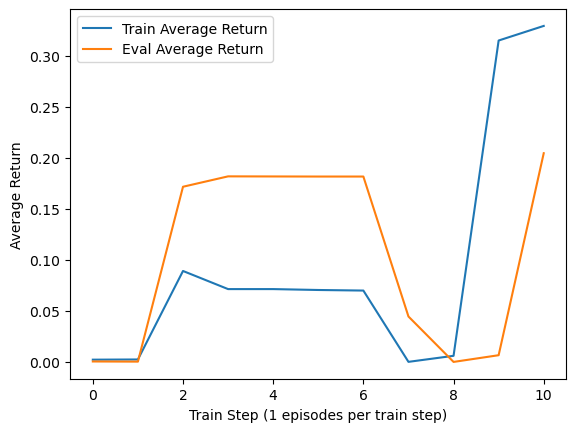

In [22]:
import matplotlib.pyplot as plt

plt.plot(trn_returns, label="Train Average Return")
plt.plot(evl_returns, label="Eval Average Return")
plt.ylabel("Average Return")
plt.xlabel(f"Train Step ({episodes_per_train_step} episodes per train step)")
plt.legend()
plt.show()

#### Visualizing Policy Execution

-----

In [23]:
time_step = tf_env.reset()
_ = evl_driver.run(time_step)

In [24]:
plotter = cplt.Plotter({"env": tf_env})
plotter.draw("3d", zrange=None)